In [1]:
#Descarga de Indices
import pandas_datareader.data as web
indices_tickers =["^IBEX","^GSPC","^DJI","^IXIC","^N225","^KS11","XIU.TO","^HSI","^MXX","^VIX"]

def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

indices_data = get_adj_closes(indices_tickers,start_date="2019-12-31",end_date="2020-03-30")
indices_data = indices_data[0:-1]

In [2]:
indices_data

Symbols,^IBEX,^GSPC,^DJI,^IXIC,^N225,^KS11,XIU.TO,^HSI,^MXX,^VIX
Date,,,,,,,,,,
2019-12-31,9549.200195,3230.780029,28538.439453,8972.599609,NaN,NaN,25.375320,28189.750000,43541.019531,13.780000
2020-01-02,9691.200195,3257.850098,28868.800781,9092.190430,NaN,2175.169922,25.444815,28543.519531,44437.230469,12.470000
2020-01-03,9646.599609,3234.850098,28634.880859,9020.769531,NaN,2176.459961,25.375320,28451.500000,44624.851562,14.020000
2020-01-06,9600.900391,3246.280029,28703.380859,9071.469727,23204.859375,2155.070068,25.474598,28226.189453,44495.300781,13.850000
2020-01-07,9579.799805,3237.179932,28583.679688,9068.580078,23575.720703,2175.540039,25.524237,28322.060547,44157.808594,13.790000
...,...,...,...,...,...,...,...,...,...,...
2020-03-24,6717.299805,2447.330078,20704.910156,7417.859863,18092.349609,1609.969971,19.420000,22663.490234,34371.531250,61.669998
2020-03-25,6942.399902,2475.560059,21200.550781,7384.299805,19546.630859,1704.760010,20.100000,23527.189453,35536.699219,63.950001
2020-03-26,7033.200195,2630.070068,22552.169922,7797.540039,18664.599609,1686.239990,20.520000,23352.339844,35706.570312,61.000000


In [3]:
indices_data.plot()

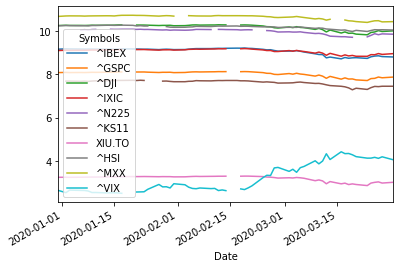

In [4]:
import numpy as np
log_indices = np.log(indices_data)
log_indices.plot()

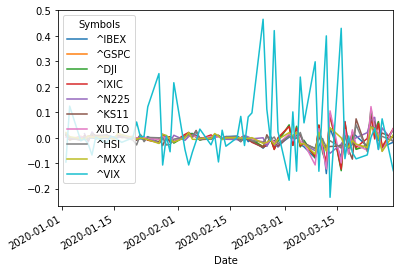

In [5]:
rend_indices = indices_data.pct_change()
rend_indices.plot()

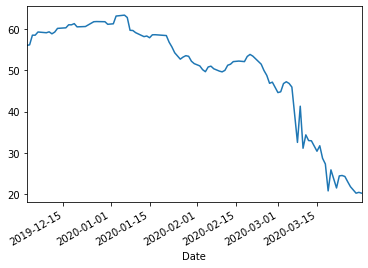

In [6]:
oil_data = get_adj_closes("CL=F",start_date="2019-12-01",end_date="2020-03-30")
oil_data.plot()

el valor minimo es -0.29106754174766314  y el máximo es 0.2685924283302341


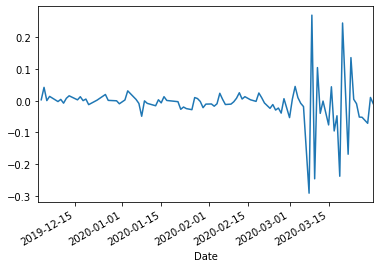

In [7]:
rend_oil = oil_data.pct_change()
rend_oil.plot()
print("el valor minimo es", rend_oil.min()," y el máximo es", rend_oil.max())

Now that we've defined these interfaces, let's look at the results of the four KDE approaches. We'll start with the normal matplotlib backend command, and then plot visualizations of the four results on the same 1 dimensional bimodal data:

In [8]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw = 'cv_ml',#bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

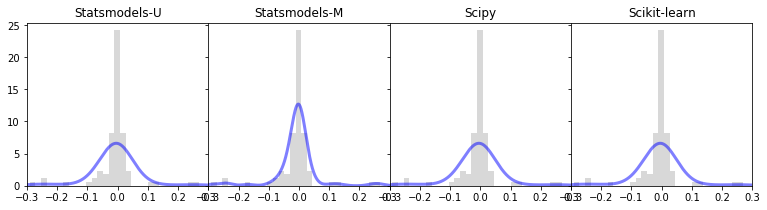

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
N_1 = 10000
# The grid we'll use for plotting
x_grid = np.linspace(-0.3,0.3, N_1)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.asarray(rend_oil[1:])

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.05)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-0.3, 0.3)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")


The selection of bandwidth is an important piece of KDE. For the same input data, different bandwidths can produce very different results:

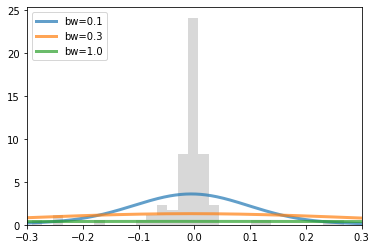

In [10]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(-0.3, 0.3)
ax.legend(loc='upper left')

Using cross validation within Scikit-learn is straightforward with the GridSearchCV meta-estimator:

In [11]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.001, 1.0, 300)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

{'bandwidth': 0.021046822742474915}


C:\Users\DParis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


According to the cross-validation score (i.e. the maximum likelihood), the best bandwidth is around 0.24 Let's plot the result:

SKLEARN


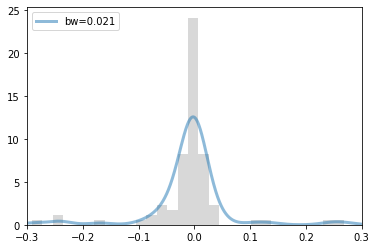

In [12]:
kde = grid.best_estimator_
pdf_sk = np.exp(kde.score_samples(x_grid[:, None]))
print("SKLEARN")
fig, ax = plt.subplots()
ax.plot(x_grid, pdf_sk, linewidth=3, alpha=0.5, label='bw=%.3f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-0.3, 0.3);

statsmodel


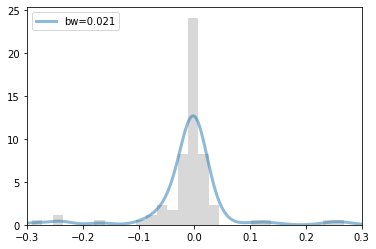

In [13]:
pdf_stats = kde_statsmodels_m(x, x_grid, bandwidth=kde.bandwidth)
print("statsmodel")
fig, ax = plt.subplots()
ax.plot(x_grid, pdf_stats, linewidth=3, alpha=0.5, label='bw=%.3f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-0.3, 0.3);

Ya que tenemos la pdf, procederemos con el método de aceptacion y rechazo, para genrar variables aleatorias:

In [14]:
def plot_Acep_rechazo(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
    f_x = f
    t_x = t
    condition = R2*t_x <= f_x
    
    [plt.plot(R1[i],R2[i]*t_x[i],'ob',markersize=1) if condition[i] else plt.plot(R1[i],R2[i]*t_x[i],'o',markersize=1) for i in range(len(R1))]
                
    plt.show()

def data_Acep_rechazo(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
    f_x = f
    t_x = t
    condition = R2*t_x <= f_x
    
    alea = [R1[i] for i in range(len(R1)) if condition[i]]

                
    return alea

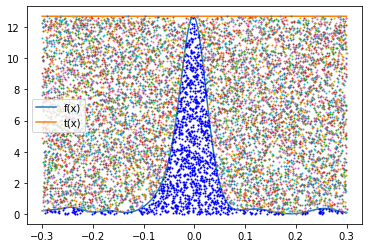

In [15]:
f = pdf_stats
# Máximo de la función f
max_f = np.max(f)
# Función t -> Función constante
t = max_f*np.ones(len(x_grid)) # función constante

# Gráficas de las funciones
plt.plot(x_grid,pdf_stats,label='f(x)')
plt.plot(x_grid,t,label='t(x)')
plt.legend()

# Como estoy tomando t(x) constante solo es necesario generar valores aleatorios U~(0,1)
R2 = np.random.rand(N_1)
R1 = x_grid
plot_Acep_rechazo(R2,R1,f,t)

In [16]:
data_OIL_RAND = data_Acep_rechazo(R2,R1,f,t)

Datos generados y PDF encontrada


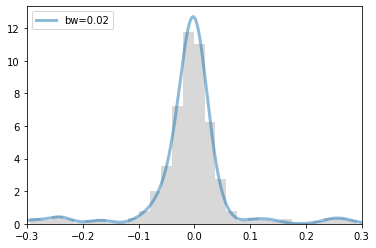

In [17]:
print("Datos generados y PDF encontrada")
fig, ax = plt.subplots()
ax.plot(x_grid, pdf_stats, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.hist(data_OIL_RAND, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-0.3, 0.3);

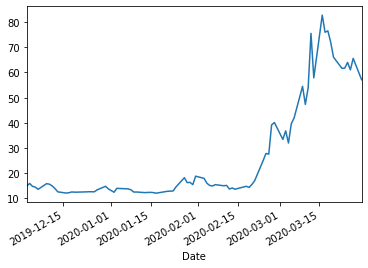

In [18]:
#VIX
vix_data = get_adj_closes("^VIX",start_date="2019-12-01",end_date="2020-03-30")
vix_data.plot()

el valor minimo es -0.2337352471753954  y el máximo es 0.46545672122078363


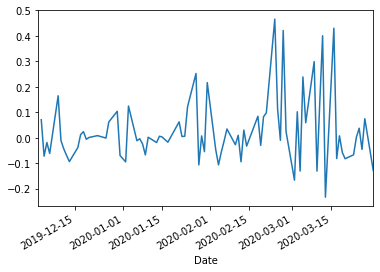

In [19]:
rend_vix = vix_data.pct_change()
rend_vix.plot()
print("el valor minimo es", rend_vix.min()," y el máximo es", rend_vix.max())

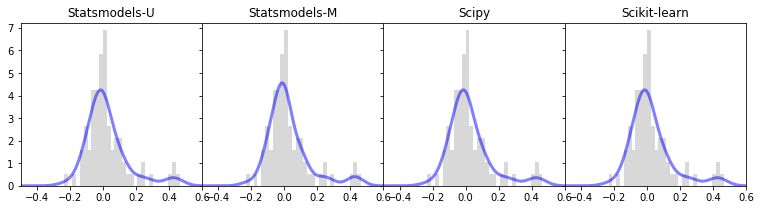

In [20]:
N_1 = 10000
# The grid we'll use for plotting
x_grid = np.linspace(-0.5,0.6, N_1)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.asarray(rend_vix[1:])

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.05)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-0.5, 0.6)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")


In [21]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.001, 1.0, 300)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

{'bandwidth': 0.04443478260869565}


C:\Users\DParis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


statsmodel


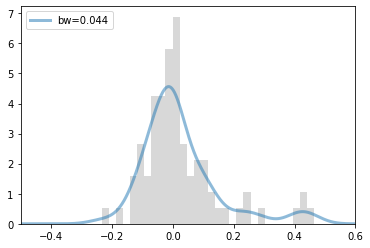

In [22]:
kde = grid.best_estimator_
pdf_stats = kde_statsmodels_m(x, x_grid, bandwidth=kde.bandwidth)
print("statsmodel")
fig, ax = plt.subplots()
ax.plot(x_grid, pdf_stats, linewidth=3, alpha=0.5, label='bw=%.3f' % kde.bandwidth)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-0.5, 0.6);

Ya que tenemos la pdf, procederemos con el método de aceptacion y rechazo, para genrar variables aleatorias:

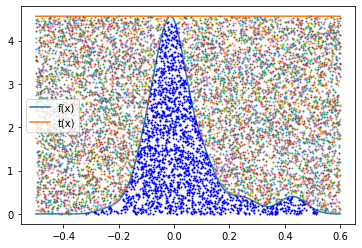

In [23]:
f = pdf_stats
# Máximo de la función f
max_f = np.max(f)
# Función t -> Función constante
t = max_f*np.ones(len(x_grid)) # función constante

# Gráficas de las funciones
plt.plot(x_grid,pdf_stats,label='f(x)')
plt.plot(x_grid,t,label='t(x)')
plt.legend()

# Como estoy tomando t(x) constante solo es necesario generar valores aleatorios U~(0,1)
R2 = np.random.rand(N_1)
R1 = x_grid
plot_Acep_rechazo(R2,R1,f,t)

Datos generados y PDF encontrada


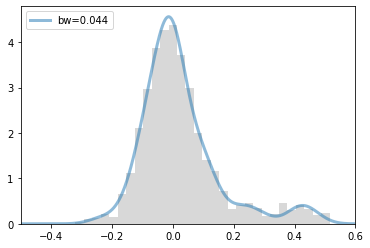

In [24]:
rend_vix_RAND = data_Acep_rechazo(R2,R1,f,t)

print("Datos generados y PDF encontrada")
fig, ax = plt.subplots()
ax.plot(x_grid, pdf_stats, linewidth=3, alpha=0.5, label='bw=%.3f' % kde.bandwidth)
ax.hist(rend_vix_RAND, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')
ax.set_xlim(-0.5, 0.6);

In [25]:
corr_ind_oil = indices_data.iloc[:,:-1].corrwith(oil_data)
corr_ind_oil

Symbols
^IBEX     0.923803
^GSPC     0.909696
^DJI      0.921919
^IXIC     0.864481
^N225     0.917338
^KS11     0.932490
XIU.TO    0.900650
^HSI      0.961288
^MXX      0.945271
dtype: float64

In [26]:
indices_data.iloc[:,:-1].corrwith(vix_data)

Symbols
^IBEX    -0.974886
^GSPC    -0.971482
^DJI     -0.975884
^IXIC    -0.958318
^N225    -0.974514
^KS11    -0.941974
XIU.TO   -0.955331
^HSI     -0.936073
^MXX     -0.955654
dtype: float64

In [27]:
def estimate(data_indice,data_RAND, N_est,corr):
    """
    Estima 1 vez el precio, con los datos de rendimiento y su correlación.
    @data_indice = array con los precios originales
    @data_rand = rendimientos aleatorios
    @N_est = Número de datos a estimar
    @corr = correlación entre los precios originales y los precios de los rendimientos aleatorios
    """
    import random
    N_precios = N_est
    random_index_rend = [random.choice(data_RAND)*corr for i in range(len(data_RAND))]
    random_index_price = np.zeros(N_precios+1)
    random_index_price[0] = data_indice[-1]
    for i in range(N_precios):
        random_index_price[i+1] = random_index_price[i]*(1+random_index_rend[i]) 
    estim = np.concatenate((np.asarray(data_indice),random_index_price))
    plt.plot(estim,label='est')
    return estim


def plot_estim(estims,data_indice):
    """
    Grafica el promedio de estimaciones, así como 2 desviaciones estandar
    @estims =arreglo de arreglos que contienen las estimaciones
    @data_indice = precio original
    """    
    avg_est = [np.average([estims[i][j] for i in range(len(estims))]) for j in range(len(estims[0]))]
    std_est = [np.std([estims[i][j] for i in range(len(estims))]) for j in range(len(estims[0]))]
    liminf = [avg_est[i] - 2*std_est[i] if avg_est[i] - 2*std_est[i] >0 else 0 for i in range(len(std_est))]
    limsup = [avg_est[i] + 2*std_est[i] for i in range(len(std_est))]

    plt.fill_between(range(np.asarray(avg_est).shape[0]), limsup, liminf,color="k", alpha=.5)
    plt.plot(avg_est,label='avg',c="r")
    plt.plot(liminf,"k--", label='std')
    plt.plot(limsup,"k--",label='std')
    plt.plot(np.asarray(data_indice),label='orig',c="y")

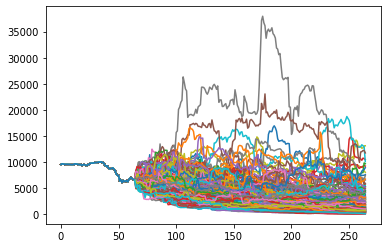

In [28]:
ibex_estims = [estimate(indices_data.iloc[:,0],data_OIL_RAND,N_est=200,corr=corr_ind_oil[0]) for i in range(200)] 
plt.plot(np.asarray(indices_data.iloc[:,0]),label='orig')

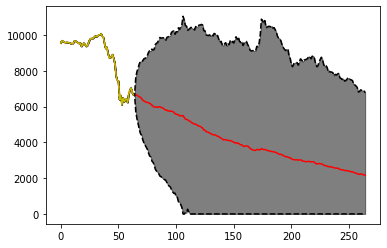

In [29]:
plot_estim(estims=ibex_estims,data_indice=indices_data.iloc[:,0])

In [32]:
#TRABJA DE AQUI PA BAJO NOE

# Analisis COVID-19 vs Stock Market
El índice VIX también se conoce comúnmente como índice de sentimiento del inversor, índice del miedo, índice VIX, cboe VIX o S&P500 VIX.

Pero, ¿qué información aporta el índice VIX? El VIX mide la volatilidad del mayor índice bursátil estadounidense, el S&P, que incluye 500 empresas, lo que lo convierte en un índice psicológico.

En los mercados, la volatilidad representa confianza o miedo.

Cuando el VIX tiende a 0, refleja un sentimiento de confianza de los inversores en la economía estadounidense.
Cuando el VIX tiende a 100, refleja pesimismo o miedo por parte de estos mismos inversores.
Hay tres niveles de alcance en el VIX cboe:

Entre 0 y 20: hay poca volatilidad en el mercado, los inversores tienen confianza y el S&P500 está en principio en tendencia alcista.
Entre 20 y 30: los inversores empiezan a preocuparse, lo que conduce a la volatilidad, la tendencia al alza del SP500 puede continuar pero también comenzar a revertirse.
Entre 30 y 100: ¡es el pánico por parte de los inversores! La volatilidad es particularmente alta y probablemente estamos asistiendo a una fuerte corrección o incluso a un colapso de los precios del SP500 y de los principales índices bursátiles.

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import datetimexxxx
%matplotlib inline

ModuleNotFoundError: No module named 'datetimexxxx'

In [ ]:
data = pd.read_csv('full_data.csv',index_col = 'location')
data_bk = pd.DataFrame(data)
data = pd.DataFrame(data)

In [ ]:
def data_pais(pais):
    data_pais = pd.DataFrame(data.loc[pais])
    data_pais['date'] = pd.to_datetime(data_pais.date)
    return data_pais


In [ ]:
USA = data_pais('United States')
WRL = data_pais('World')


In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Precio', color=color)
ax1.plot(indices_data.index, indices_data['^VIX'], color=color,label = 'VIX')
plt.legend(loc='center left')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation = 90)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Casos COVID-19 Confirmados', color=color)  # we already handled the x-label with ax1
ax2.plot(USA['date'],USA['total_cases'], color=color,label = 'COVID-19')
ax2.tick_params(axis='y', labelcolor=color)


plt.legend(loc='upper left')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [ ]:
%matplotlib notebook
title = 'COVID-19'
x = np.array(USA['date'])
y = np.array(USA['total_cases'])
overdose = pd.DataFrame(y,x)
overdose.columns = {title}
overdose

In [ ]:
def animate(i):
    data = overdose.iloc[:int(i+1)] #select data range
    p = sns.lineplot(x=data.index, y=data[title], data=data, color="r")
    p.tick_params(labelsize=10)
    plt.setp(p.lines,linewidth=7)

In [ ]:
fig = plt.figure(figsize=(10,6))
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100, repeat=True)



plt.ylim(np.min(overdose)[0], np.max(overdose)[0])
plt.xticks(rotation=90)
plt.title('COVID-CASES',fontsize=10)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web

In [ ]:
netflix = web.get_data_yahoo("NFLX",
                            start = "2009-01-01",
                            end = "2018-03-01")
netflix

In [ ]:
netflix['Adj Close'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("Netflix Price data")
plt.show()

In [ ]:
netflix_daily_returns = netflix['Adj Close'].pct_change()
netflix_monthly_returns = netflix['Adj Close'].resample('M').ffill().pct_change()

In [ ]:
print(netflix_daily_returns.head())

In [ ]:
print(netflix_monthly_returns.head())

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(netflix_daily_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Netflix daily returns data")
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(netflix_monthly_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Netflix monthly returns data")
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
netflix_daily_returns.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Netflix daily returns data")
ax1.text(-0.35,200,"Extreme Low\nreturns")
ax1.text(0.25,200,"Extreme High\nreturns")
plt.show()

In [ ]:
netflix_cum_returns = (netflix_daily_returns + 1).cumprod()

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
netflix_cum_returns.plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title("Netflix daily cumulative returns data")
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
netflix_cum_returns = (netflix_monthly_returns + 1).cumprod()
ax1.plot(netflix_cum_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title("Netflix Monthly cumulative returns data")
plt.show()